# R Aqr JWST MIRI coronagraph offset
Calculations of X,Y offset for R Aqr offset target acquisition
for MIRI coronagraphs.

In [1]:
# Set up autoloader
%load_ext autoreload
%autoreload 2

In [2]:
# Set up modules and stuff
import numpy as np
import astropy.units as u
import compute_offsets as coff
from astropy.time import Time
from astropy.coordinates import SkyCoord, Distance

## JWST Parameters
This is the date range for the scheduled JWST observation, and camera configuration.

In [3]:
# JWST PA angle of the telescope V3 axis at time of observation
# V3PA range found in APT -> Visit Planner -> Reports -> Visit -> Total Roll
V3PA_TIME_R1 = 55.000 # Chosen V3PA at the JWST observing time (roll 1)
V3PA_TIME_R2 = 63.000 # Chosen V3PA at the JWST observing time (roll 2)
V3PA_TIME1 = 55.000 # Chosen V3PA at the beginning of JWST observing window
V3PA_TIME2 = 65.000 # Chosen V3PA at the end of JWST observing window

# Coronographic mask ids
CORON_ID_A = '1140' # ID for first coronagraphic observation
CORON_ID_B = '1550' # ID for second coronagraphic observation

In [4]:
# JWST dates and times
JWST_TIME = '2024-11-14T00:00:00.000'     # Time of observation
JWST_TIME1 = '2024-10-27T14:01:00.000'    # Beginning of JWST observing window
JWST_TIME2 = '2024-12-02T00:19:52.000'    # End of JWST observing window

# Create Time-like objects with the JWST times
jwst_time = Time(JWST_TIME1, format='isot', scale='utc')
jwst_time1 = Time(JWST_TIME1, format='isot', scale='utc')
jwst_time2 = Time(JWST_TIME2, format='isot', scale='utc')

## Reference coordinates for R Aqr and offset star
We provide the most recent set of coordinates and proper motion for R Aqr based on our VLBI observations. The acquisition star coordinates are from Gaia DR3.

In [5]:
# R Aqr VLBI coordinates and proper motion
RA = '23:43:49.50785 hours'     # RA in sexagesimal format (ICRS)
DEC = '-15:17:04.911 degrees'   # DEC in sexagesimal format (ICRS) 
PMRA = 27.33                    # Proper motion in RA (mas/yr)
PMDEC = -30.37                  # Proper motion in DEC (mas/yr)
#PARALLAX = 2.5931              # Gaia DR3 Parallax (mas)
PARALLAX = 4.59                 # Adriantsaralaza et al. 2022 parallax (mas)
OBS_DATE = '2024-04-07'         # Observation date
EPOCH = 2000.0                  # Reference epoch
FRAME = 'icrs'                  # Coordinate frame

# Create Skycoord object with the given coordinates
r_aqr = SkyCoord(RA,
                 DEC,
                 pm_ra_cosdec=PMRA*u.mas/u.yr,
                 pm_dec=PMDEC*u.mas/u.yr,
                 distance=Distance(parallax=PARALLAX*u.mas),
                 equinox=Time(EPOCH, format='jyear'),
                 obstime=Time(OBS_DATE, format='iso', scale='utc'),
                 frame=FRAME
                )

In [6]:
# Gaia DR3 2419576255768131328 coordinates
RA = '355.9498781532638 degrees'     # RA in decimal degrees (ICRS)
DEC = '-15.283947951921947 degrees'  # DEC in decimal degrees (ICRS) 
PMRA = 20.269224605443817            # Proper motion in RA (mas/yr)
PMDEC = -11.812614959581758          # Proper motion in DEC (mas/yr)
PARALLAX = 3.7063351210713535        # Gaia DR3 Parallax (mas)
OBS_DATE = 2016.0                    # Observation date
EPOCH = 2016.0                       # Reference epoch
FRAME = 'icrs'                       # Coordinate frame

# Create Skycoord object with the given coordinates
acqt = SkyCoord(RA,
                DEC,
                pm_ra_cosdec=PMRA*u.mas/u.yr,
                pm_dec=PMDEC*u.mas/u.yr,
                distance=Distance(parallax=PARALLAX*u.mas),
                equinox=Time(EPOCH, format='jyear'),
                obstime=Time(OBS_DATE, format='jyear', scale='tcb'),
                frame=FRAME
            )

In [7]:
# Print offset between R Aqr and Gaia DR3 2419576255768131328
# Based on their nominal coordinates and proper motions
offset = r_aqr.separation(acqt).to(u.arcsec)
pa_offset = r_aqr.position_angle(acqt).to(u.deg)
print(f'--> Total Offset with R Aqr:   {offset:.6f}')
print(f'--> Position angle with R Aqr: {pa_offset:.4f}')

--> Total Offset with R Aqr:   22.403976 arcsec
--> Position angle with R Aqr: 276.9168 deg


## Update coordinates for R Aqr and acquisition star
Update position of R Aqr and acquisition star to initial and final date of observing window. Use the apply_space_motion() method of the SkyCoord package. 

In [9]:
# Update VLBI coordinates of R Aqr to JWST observing time
r_aqr_time = r_aqr.apply_space_motion(new_obstime=jwst_time)

# Update VLBI coordinates of R Aqr to beggining of JWST observing window
r_aqr_time1 = r_aqr.apply_space_motion(new_obstime=jwst_time1)

# Update VLBI coordinates of R Aqr to the end of JWST observing window
r_aqr_time2 = r_aqr.apply_space_motion(new_obstime=jwst_time2)

# Print R Aqr change in  position during JWST observing window
offset_jwst = r_aqr_time2.separation(r_aqr_time1).to(u.mas)
pa_offset_jwst = r_aqr_time2.position_angle(r_aqr_time1).to(u.deg)
print('--> R Aqr change in position during JWST observing window:')
print(f'--> Total Offset:   {offset_jwst:.3f}')
print(f'--> Position angle: {pa_offset_jwst:.2f}')

--> R Aqr change in position during JWST observing window:
--> Total Offset:   3.963 mas
--> Position angle: 318.02 deg


In [65]:
# Update coordinates of acquisition star to JWST observing time
acqt_time = acqt.apply_space_motion(new_obstime=jwst_time)

# Update coordinates of acquisition star to beggining of JWST observing window
acqt_time1 = acqt.apply_space_motion(new_obstime=jwst_time1)

# Update coordinates of acquisition star to end of JWST observing window
acqt_time2 = acqt.apply_space_motion(new_obstime=jwst_time2)

# Print acquisition star change in  position during JWST observing window
offset_jwst = acqt_time2.separation(acqt_time1).to(u.mas)
pa_offset_jwst = acqt_time2.position_angle(acqt_time1).to(u.deg)
print('--> Acquisition star change in position during JWST observing window:')
print(f'--> Total Offset:   {offset_jwst:.3f}')
print(f'--> Position angle: {pa_offset_jwst:.2f}')

--> Acquisition star change in position during JWST observing window:
--> Total Offset:   2.276 mas
--> Position angle: 300.23 deg


In [66]:
# Print offset between R Aqr and Gaia DR3 2419576255768131328
# Based on their nominal coordinates and proper motions at JWST observing time
offset_time = r_aqr_time.separation(acqt_time).to(u.arcsec)
pa_offset_time = r_aqr.position_angle(acqt_time).to(u.deg)
print(f'--> Total Offset with R Aqr (obs. time):   {offset_time:.6f}')
print(f'--> Position angle with R Aqr (obs. time): {pa_offset_time:.4f}')

--> Total Offset with R Aqr (obs. time):   22.231180 arcsec
--> Position angle with R Aqr (obs. time): 276.7055 deg


## Calculate APT offset for target acquisition
Uses the compute_offsets() script to calculate the dx and dy offset needed in APT to perform the target acquisition in offset from the acquisition star. This needs to be done for all JWST coronagraphs that need to be used, and for the time of beginning and end of the observing window. 

In [67]:
# Setup initial and final slew coordinates for offset script
R_AQR_RA = r_aqr_time.ra.deg
R_AQR_RA1 = r_aqr_time1.ra.deg
R_AQR_RA2 = r_aqr_time2.ra.deg
R_AQR_DEC = r_aqr_time.dec.deg
R_AQR_DEC1 = r_aqr_time1.dec.deg
R_AQR_DEC2 = r_aqr_time2.dec.deg
ACQT_RA = acqt_time.ra.deg
ACQT_RA1 = acqt_time1.ra.deg
ACQT_RA2 = acqt_time2.ra.deg
ACQT_DEC = acqt_time.dec.deg
ACQT_DEC1 = acqt_time1.dec.deg
ACQT_DEC2 = acqt_time2.dec.deg

# Setup initial and final slew coordinates for JWST observing time
slew_to = {'label': 'R Aqr', 
           'position': SkyCoord(R_AQR_RA, R_AQR_DEC,
                                unit='deg', frame='icrs')
          }

slew_from = {'label': 'Acquisition Star', 
             'position': SkyCoord(ACQT_RA, ACQT_DEC,
                                  unit='deg', frame='icrs')
             }

# Setup initial and final slew coordinates for beginning of observing window
slew_to1 = {'label': 'R Aqr', 
            'position': SkyCoord(R_AQR_RA1, R_AQR_DEC1,
                                 unit='deg', frame='icrs')
          }

slew_from1 = {'label': 'Acquisition Star', 
              'position': SkyCoord(ACQT_RA1, ACQT_DEC1,
                                   unit='deg', frame='icrs')
             }

# Setup initial and final slew coordinates for beginning of observing window
slew_to2 = {'label': 'R Aqr', 
            'position': SkyCoord(R_AQR_RA2, R_AQR_DEC2,
                                 unit='deg', frame='icrs')
          }

slew_from2 = {'label': 'Acquisition Star', 
              'position': SkyCoord(ACQT_RA2, ACQT_DEC2,
                                   unit='deg', frame='icrs')
             }

In [68]:
# Decide if plotting or not
SHOW_PLOTS = True
PLOT_FULL = True

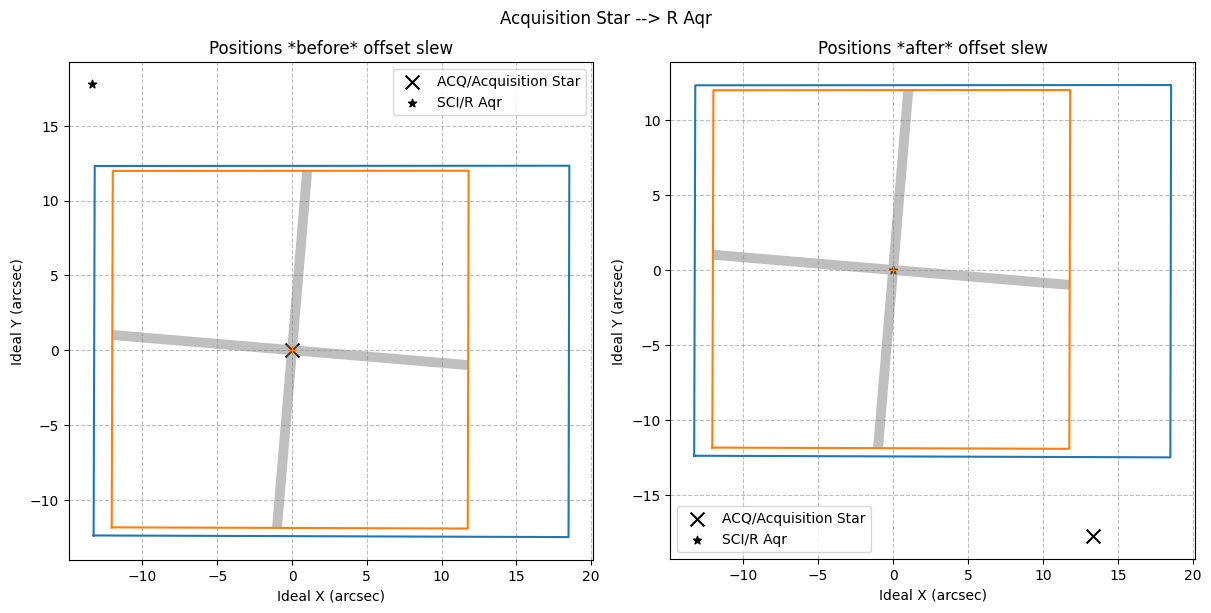

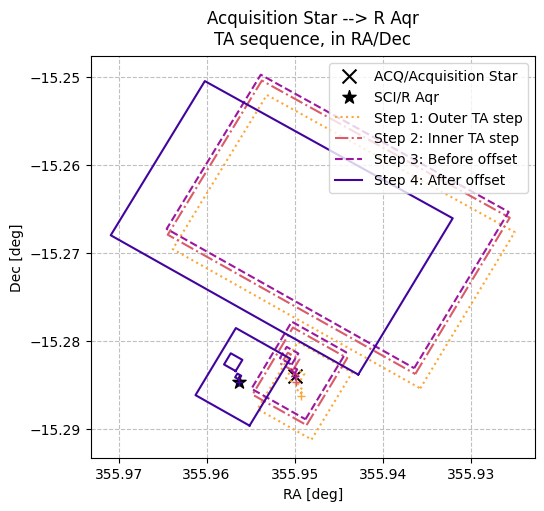

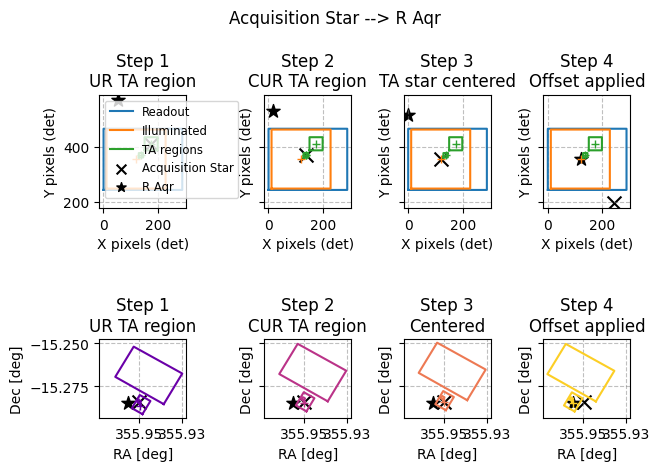

<<<=============================================================>>>
<<<=============================================================>>>
--> Offset for 4QPM 11.4 um mask at JWST observing time (roll 1):
--> Delta X: +13.35132 arcsec
--> Delta Y: -17.77550 arcsec
<<<=============================================================>>>
<<<=============================================================>>>


In [69]:
# Calculate offsets for 4QPM 11.4 um mask at JWST observing time (roll 1)
dx, dy = coff.compute_offsets(slew_from,
                              slew_to,
                              V3PA_TIME_R1,
                              CORON_ID_A,
                              verbose = False,
                              show_plots = SHOW_PLOTS,
                              plot_full = PLOT_FULL,
                              return_offsets = True
                              )

# Print offsets
print('<<<=============================================================>>>')
print('<<<=============================================================>>>')
print(f'--> Offset for 4QPM 11.4 um mask at JWST observing time (roll 1):')
print(f'--> Delta X: {dx:+4.5f} arcsec')
print(f'--> Delta Y: {dy:+4.5f} arcsec')
print('<<<=============================================================>>>')
print('<<<=============================================================>>>')

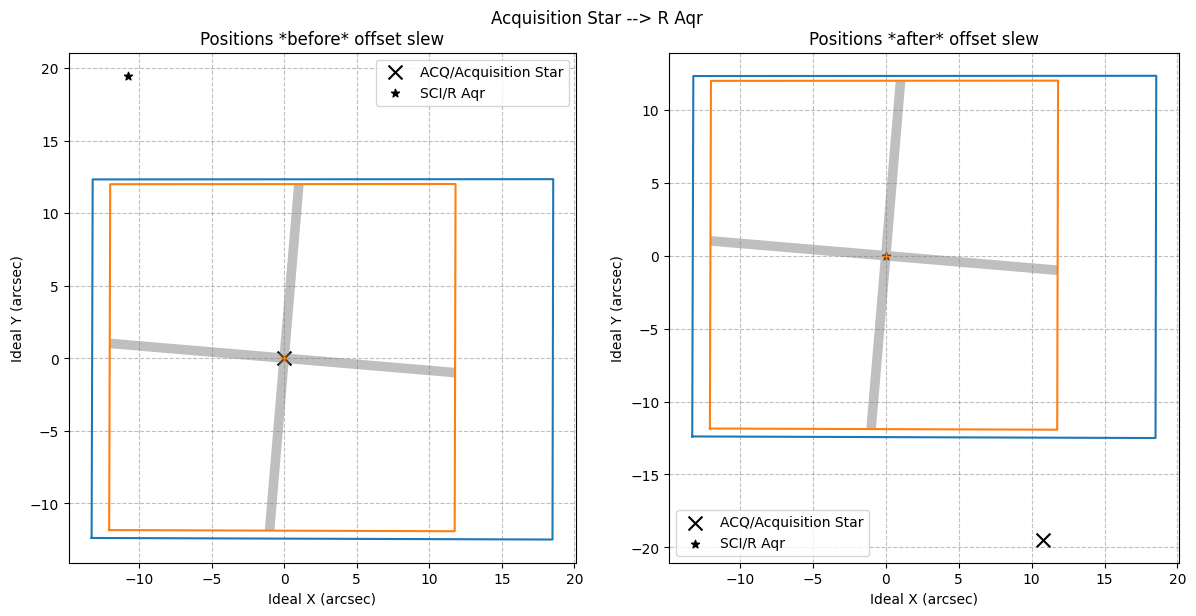

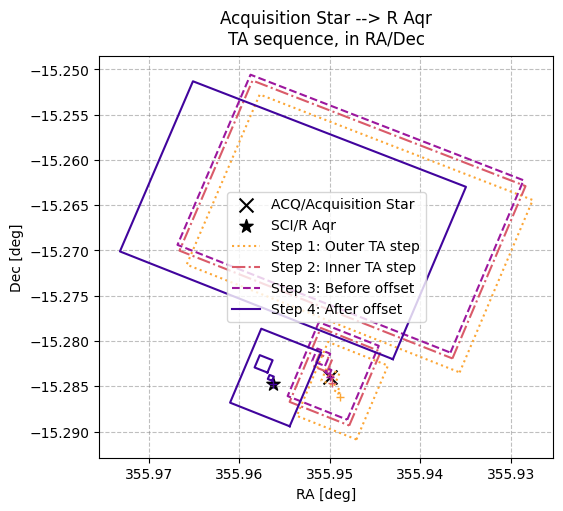

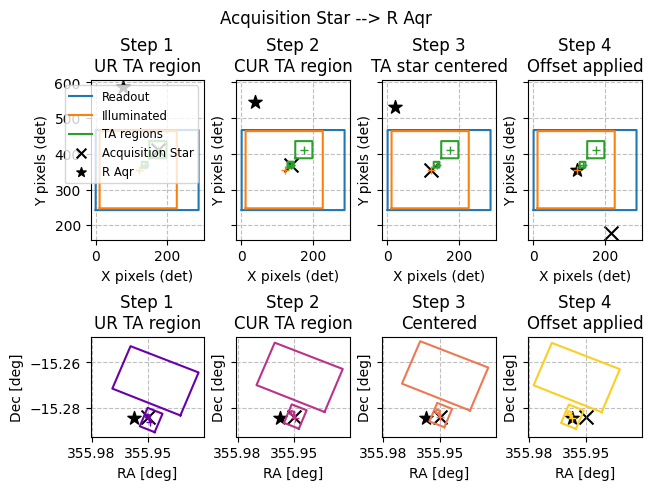

<<<=============================================================>>>
<<<=============================================================>>>
--> Offset for 4QPM 11.4 um mask at JWST observing time (roll 2):
--> Delta X: +10.74751 arcsec
--> Delta Y: -19.46065 arcsec
<<<=============================================================>>>
<<<=============================================================>>>


In [70]:
# Calculate offsets for 4QPM 11.4 um mask at JWST observing time (roll 2)
dx, dy = coff.compute_offsets(slew_from,
                              slew_to,
                              V3PA_TIME_R2,
                              CORON_ID_A,
                              verbose = False,
                              show_plots = SHOW_PLOTS,
                              plot_full = PLOT_FULL,
                              return_offsets = True
                              )

# Print offsets
print('<<<=============================================================>>>')
print('<<<=============================================================>>>')
print(f'--> Offset for 4QPM 11.4 um mask at JWST observing time (roll 2):')
print(f'--> Delta X: {dx:+4.5f} arcsec')
print(f'--> Delta Y: {dy:+4.5f} arcsec')
print('<<<=============================================================>>>')
print('<<<=============================================================>>>')

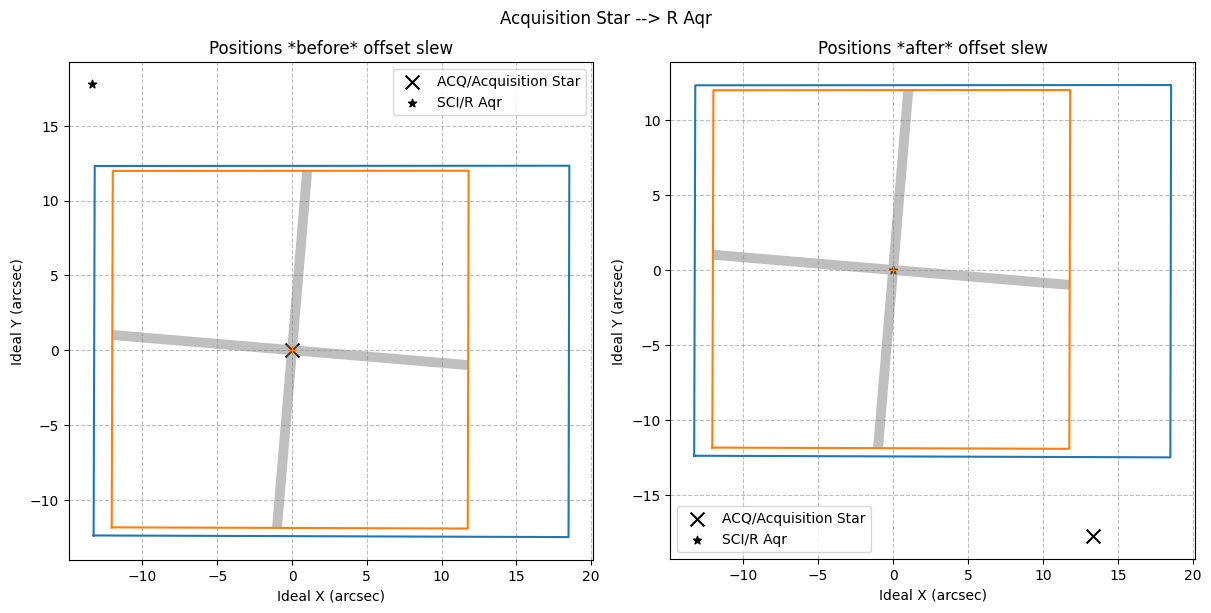

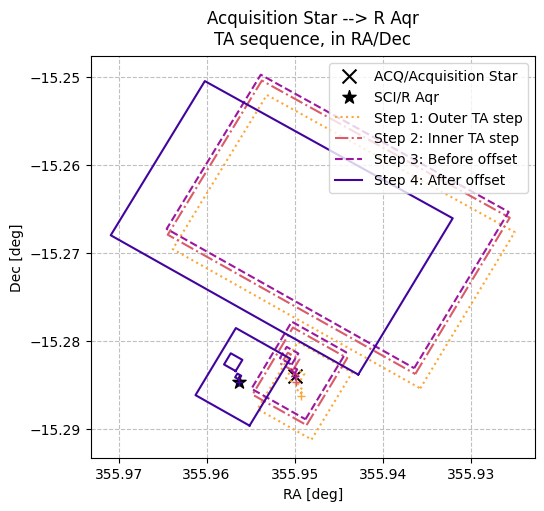

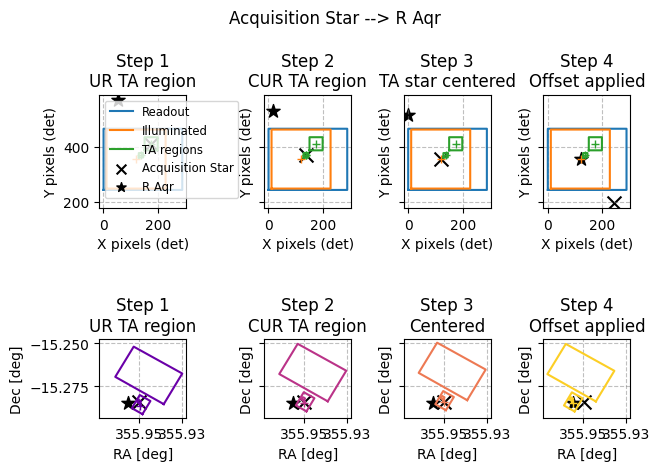

<<<==========================================================>>>
--> Offset for 4QPM 11.4 um mask at JWST observing window start:
--> Delta X: +13.35132 arcsec
--> Delta Y: -17.77550 arcsec
<<<==========================================================>>>


In [71]:
# Calculate offsets for 4QPM 11.4 um mask at JWST observing window start
dx, dy = coff.compute_offsets(slew_from1,
                              slew_to1,
                              V3PA_TIME1,
                              CORON_ID_A,
                              verbose = False,
                              show_plots = SHOW_PLOTS,
                              plot_full = PLOT_FULL,
                              return_offsets = True
                              )

# Print offsets
print('<<<==========================================================>>>')
print(f'--> Offset for 4QPM 11.4 um mask at JWST observing window start:')
print(f'--> Delta X: {dx:+4.5f} arcsec')
print(f'--> Delta Y: {dy:+4.5f} arcsec')
print('<<<==========================================================>>>')

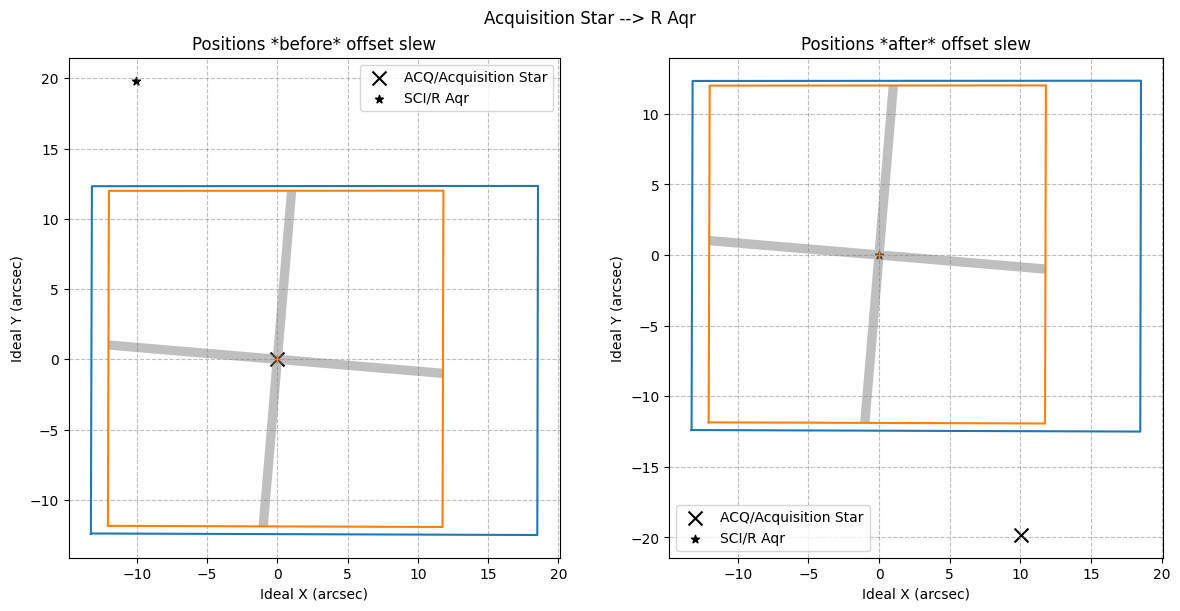

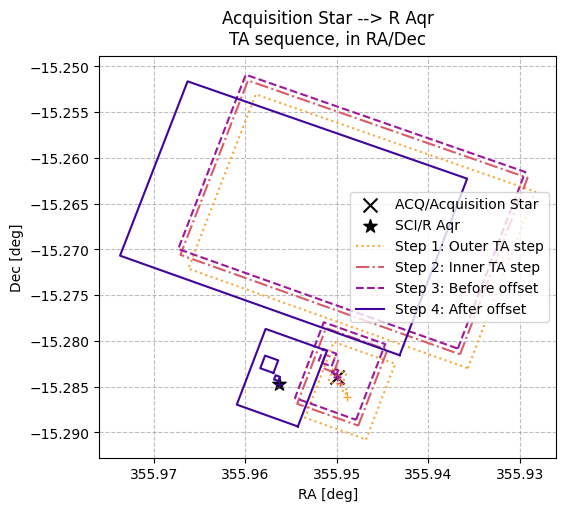

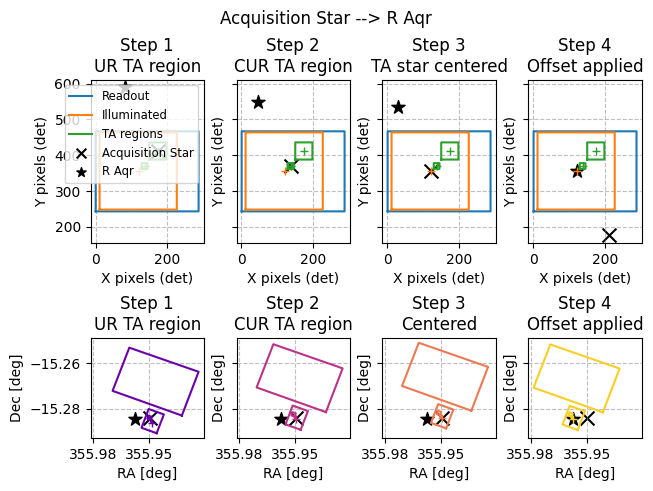

<<<==========================================================>>>
--> Offset for 4QPM 11.4 um mask at JWST observing window end:
--> Delta X: +10.06372 arcsec
--> Delta Y: -19.82390 arcsec
<<<==========================================================>>>


In [72]:
# Calculate offsets for 4QPM 11.4 um mask at JWST observing window end
dx, dy = coff.compute_offsets(slew_from2,
                              slew_to2,
                              V3PA_TIME2,
                              CORON_ID_A,
                              verbose = False,
                              show_plots = SHOW_PLOTS,
                              plot_full = PLOT_FULL,
                              return_offsets = True
                              )

# Print offsets
print('<<<==========================================================>>>')
print(f'--> Offset for 4QPM 11.4 um mask at JWST observing window end:')
print(f'--> Delta X: {dx:+4.5f} arcsec')
print(f'--> Delta Y: {dy:+4.5f} arcsec')
print('<<<==========================================================>>>')

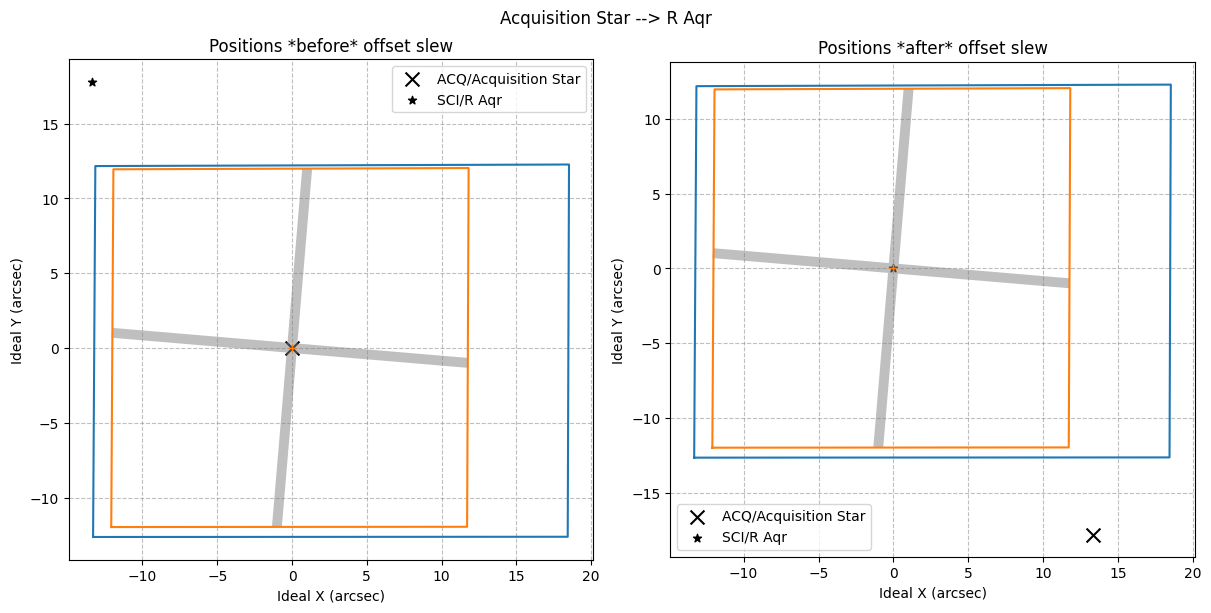

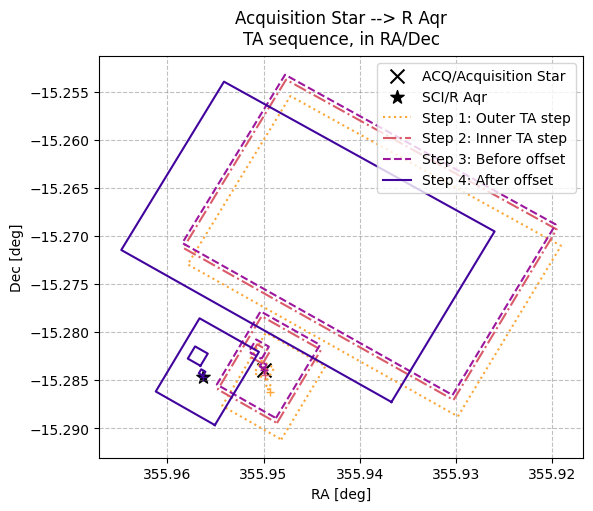

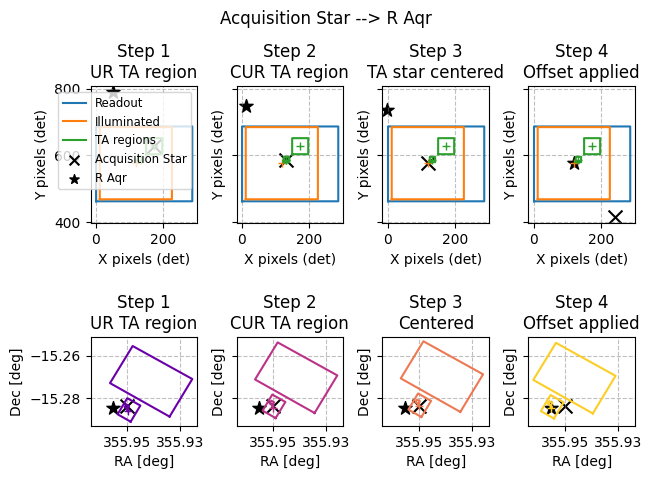

<<<=============================================================>>>
<<<=============================================================>>>
--> Offset for 4QPM 15.5 um mask at JWST observing time (roll 1):
--> Delta X: +13.35132 arcsec
--> Delta Y: -17.77550 arcsec
<<<=============================================================>>>
<<<=============================================================>>>


In [73]:
# Calculate offsets for 4QPM 15.5 um mask at JWST observing time (roll 1)
dx, dy = coff.compute_offsets(slew_from,
                              slew_to,
                              V3PA_TIME_R1,
                              CORON_ID_B,
                              verbose = False,
                              show_plots = SHOW_PLOTS,
                              plot_full = PLOT_FULL,
                              return_offsets = True
                              )

# Print offsets
print('<<<=============================================================>>>')
print('<<<=============================================================>>>')
print(f'--> Offset for 4QPM 15.5 um mask at JWST observing time (roll 1):')
print(f'--> Delta X: {dx:+4.5f} arcsec')
print(f'--> Delta Y: {dy:+4.5f} arcsec')
print('<<<=============================================================>>>')
print('<<<=============================================================>>>')

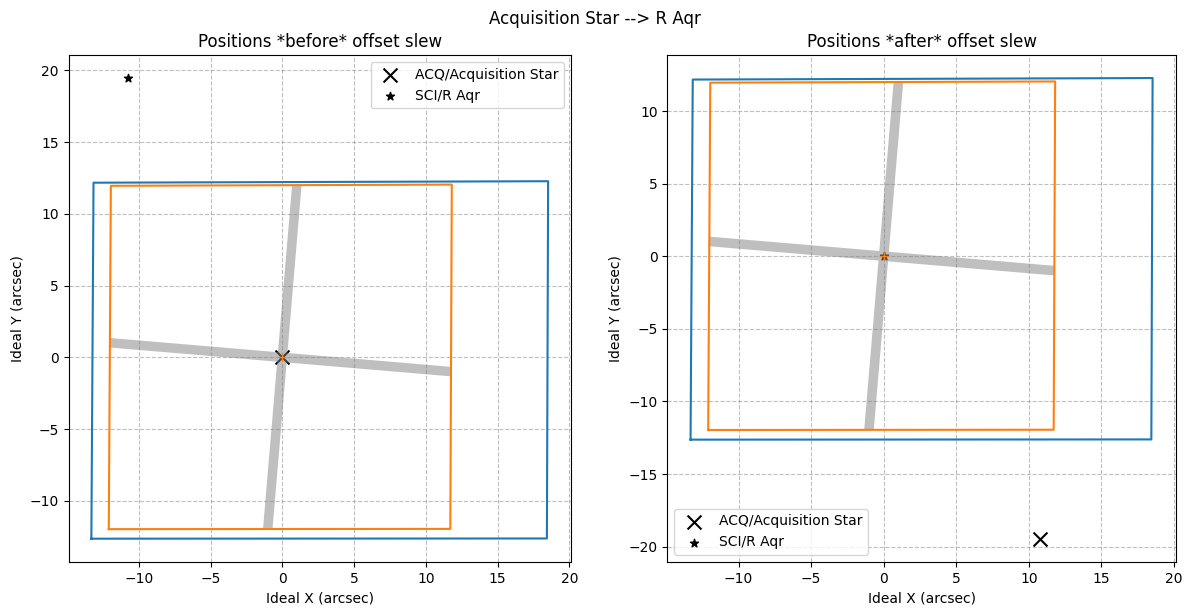

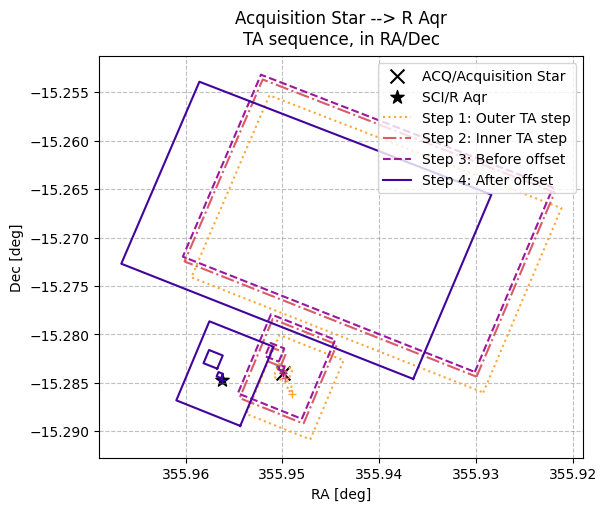

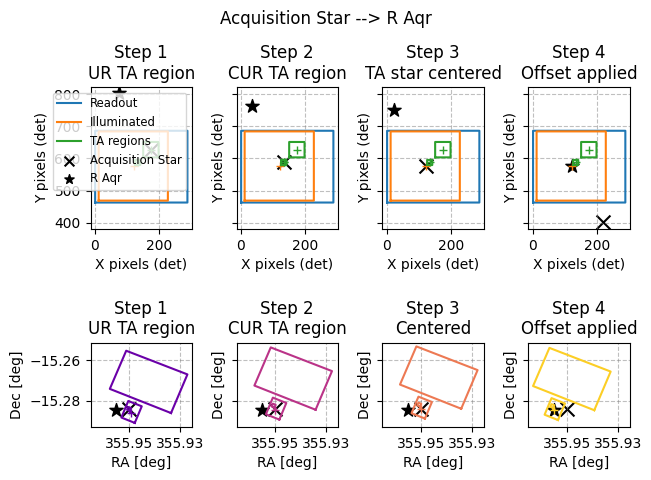

<<<=============================================================>>>
<<<=============================================================>>>
--> Offset for 4QPM 15.5 um mask at JWST observing time (roll 2):
--> Delta X: +10.74751 arcsec
--> Delta Y: -19.46065 arcsec
<<<=============================================================>>>
<<<=============================================================>>>


In [74]:
# Calculate offsets for 4QPM 15.5 um mask at JWST observing time (roll 2)
dx, dy = coff.compute_offsets(slew_from,
                              slew_to,
                              V3PA_TIME_R2,
                              CORON_ID_B,
                              verbose = False,
                              show_plots = SHOW_PLOTS,
                              plot_full = PLOT_FULL,
                              return_offsets = True
                              )

# Print offsets
print('<<<=============================================================>>>')
print('<<<=============================================================>>>')
print(f'--> Offset for 4QPM 15.5 um mask at JWST observing time (roll 2):')
print(f'--> Delta X: {dx:+4.5f} arcsec')
print(f'--> Delta Y: {dy:+4.5f} arcsec')
print('<<<=============================================================>>>')
print('<<<=============================================================>>>')

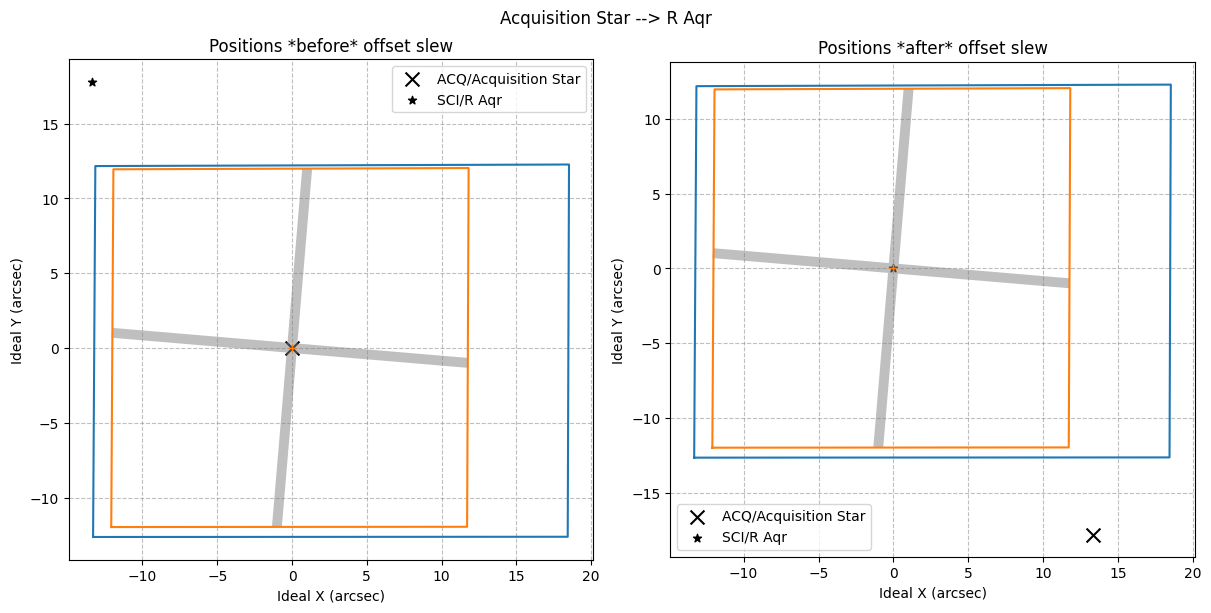

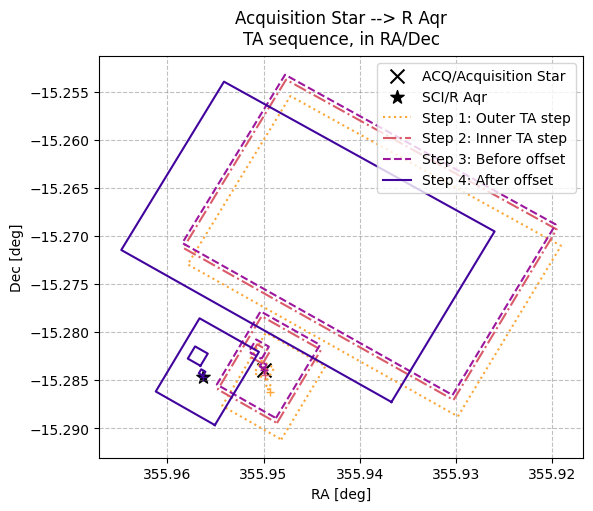

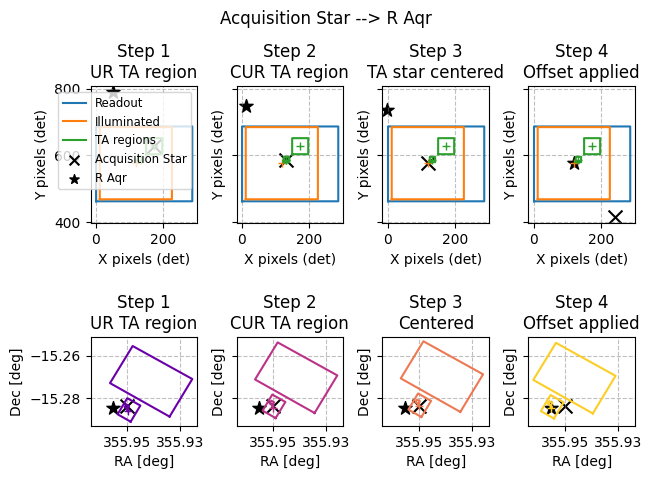

<<<==========================================================>>>
--> Offset for 4QPM 15.5 um mask at JWST observing window start:
--> Delta X: +13.35132 arcsec
--> Delta Y: -17.77550 arcsec
<<<==========================================================>>>


In [75]:
# Calculate offsets for 4QPM 15.5 um mask at JWST observing window start
dx, dy = coff.compute_offsets(slew_from1,
                              slew_to1,
                              V3PA_TIME1,
                              CORON_ID_B,
                              verbose = False,
                              show_plots = SHOW_PLOTS,
                              plot_full = PLOT_FULL,
                              return_offsets = True
                              )

# Print offsets
print('<<<==========================================================>>>')
print(f'--> Offset for 4QPM 15.5 um mask at JWST observing window start:')
print(f'--> Delta X: {dx:+4.5f} arcsec')
print(f'--> Delta Y: {dy:+4.5f} arcsec')
print('<<<==========================================================>>>')

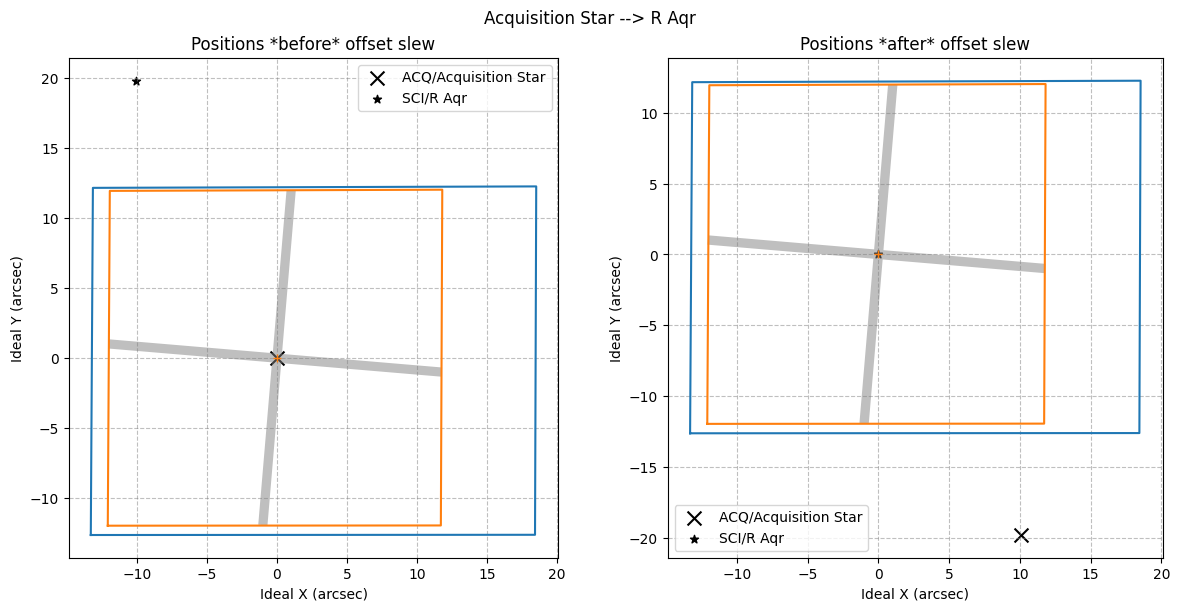

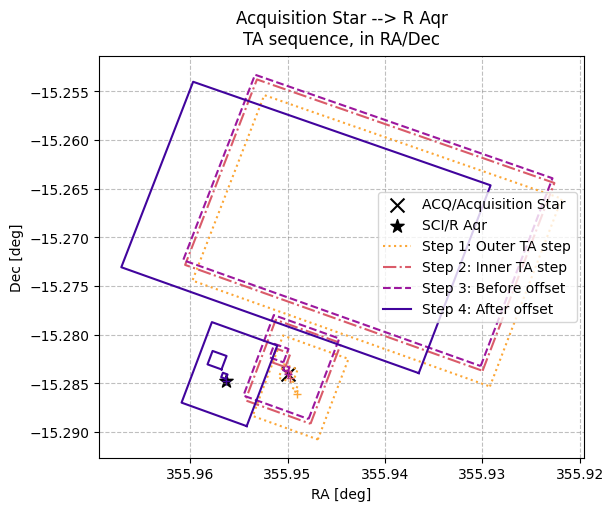

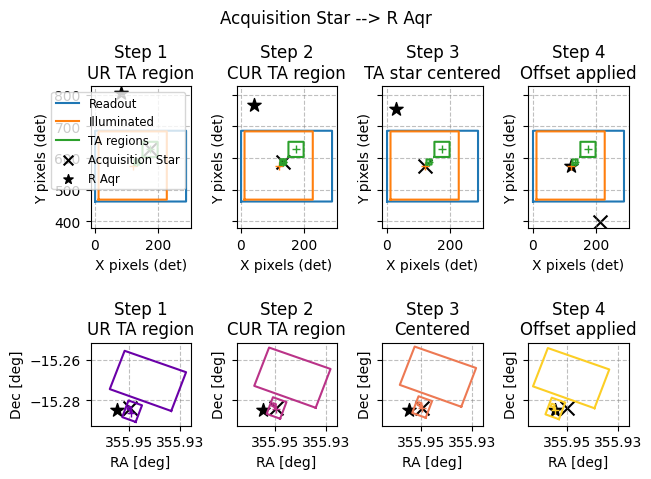

<<<==========================================================>>>
--> Offset for 4QPM 15.5 um mask at JWST observing window end:
--> Delta X: +10.06372 arcsec
--> Delta Y: -19.82390 arcsec
<<<==========================================================>>>


In [76]:
# Calculate offsets for 4QPM 15.5 um mask at JWST observing window start
dx, dy = coff.compute_offsets(slew_from2,
                              slew_to2,
                              V3PA_TIME2,
                              CORON_ID_B,
                              verbose = False,
                              show_plots = SHOW_PLOTS,
                              plot_full = PLOT_FULL,
                              return_offsets = True
                              )

# Print offsets
print('<<<==========================================================>>>')
print(f'--> Offset for 4QPM 15.5 um mask at JWST observing window end:')
print(f'--> Delta X: {dx:+4.5f} arcsec')
print(f'--> Delta Y: {dy:+4.5f} arcsec')
print('<<<==========================================================>>>')